# Blok 3

---
## Shapley values

W 2017  Lundberg and Lee opublikowali artykuł "A Unified Approach to Interpreting Model Predictions".
https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf
    
Połaczyli "Shapley values" (1951, nagroda Nobla z ekonomii 2012) z innym mechanizmami wyjaśniania modeli tworząc SHAP values (SHapley Additive exPlanations) i odpowiadającą im bibliotekę
`shap`.

https://en.wikipedia.org/wiki/Shapley_value


---
# Random Forest Classifier

https://www.kaggle.com/datasets/yufengsui/portuguese-bank-marketing-data-set

In [139]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [140]:
bank_data = pd.read_csv('data/bank-full.csv', sep=';')
bank_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


## Binaryzacja 

In [141]:
bank_data['default'] = bank_data['default'].map({'no':0,'yes':1,'unknown':0})

bank_data['y'] = bank_data['y'].map({'no':0,'yes':1})
bank_data['housing'] = bank_data['housing'].map({'no':0,'yes':1})
bank_data['loan'] = bank_data['loan'].map({'no':0,'yes':1})
bank_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,0,825,0,0,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,0,1729,0,0,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,0,5715,0,0,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,0,668,0,0,telephone,17,nov,508,4,-1,0,unknown,0


## Konwersja zmiennych kategorycznych

In [142]:
bank_data = pd.get_dummies(bank_data, columns=['job', 'marital', 'education', 'contact', 'month', 'poutcome'])
bank_data

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,261,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
1,44,0,29,1,0,5,151,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
2,33,0,2,1,1,5,76,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
3,47,0,1506,1,0,5,92,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
4,33,0,1,0,0,5,198,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,977,3,-1,0,...,0,0,0,1,0,0,0,0,0,1
45207,71,0,1729,0,0,17,456,2,-1,0,...,0,0,0,1,0,0,0,0,0,1
45208,72,0,5715,0,0,17,1127,5,184,3,...,0,0,0,1,0,0,0,0,1,0
45209,57,0,668,0,0,17,508,4,-1,0,...,0,0,0,1,0,0,0,0,0,1


In [143]:
X = bank_data.drop('y', axis=1)
y = bank_data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [144]:
y

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64

In [145]:
%%time 
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

CPU times: total: 4.28 s
Wall time: 4.3 s


RandomForestClassifier()

In [146]:
%%time 
from sklearnex.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

CPU times: total: 3.39 s
Wall time: 660 ms


RandomForestClassifier()

In [147]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9046776512219397


## Wiele estymatorów

In [148]:
len(rf.estimators_)

100

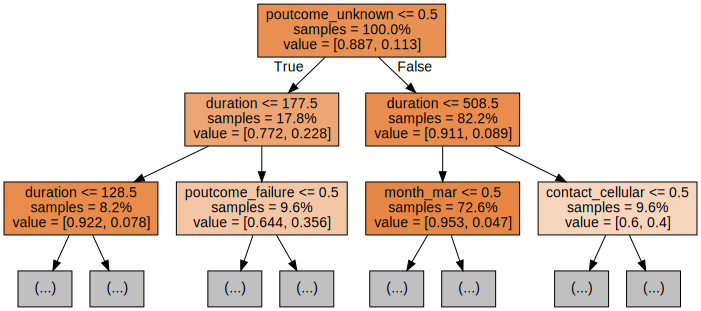

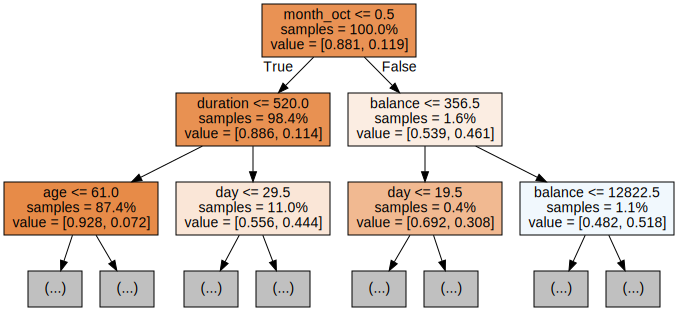

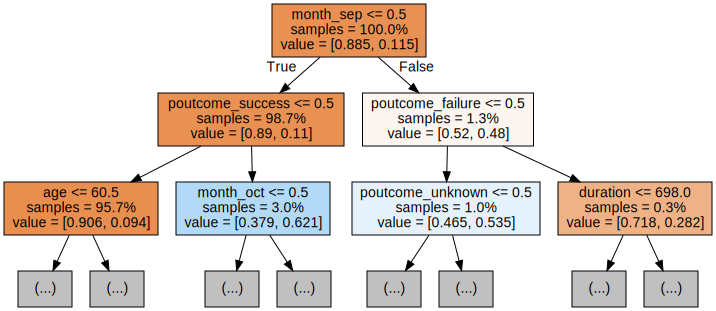

In [149]:

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## `RandomizedSearchCV`

In [150]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5, n_jobs=3)

rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5, n_jobs=3,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000029712F779D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002971B4F8550>})

## Najlepszy estymator

In [151]:
best_rf = rand_search.best_estimator_

print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 15, 'n_estimators': 149}


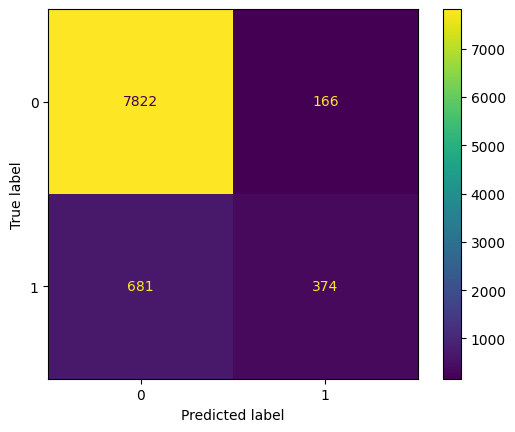

In [152]:
y_pred = best_rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

---
# XGBoost

conda install -c conda-forge xgboost

    !conda install -y -c conda-forge xgboost

## <span style="color: cyan">- Numeric features should be scaled </cyan>
## <span style="color: cyan">- Categorical features should be encoded </cyan>

# Random Forest

- ## Bagging  "Bootstrap Aggregating" - równorzędne modele na podzbiorach modelu trenującego. Wynik jest średnią z wyników
- ## Dobry dla zaszumionych zbiorów
- ## Dobre dla high variance and low bias - Wyniki są STABILNE
- ## Odporny na overfitting


# XGBoost

- ## Boosting - model jest zbudowany z serii coraz to lepszych modeli które dodają swój wynik do porzedniego. 
- ## Dobry dla niezbalansowanych zbiorów
- ## Dobre dla modeli low variance and high bias - Wyniki są DOKŁADNE
- ## Dzięki dokładności - ulubiony we wszelkich zawodach

---

https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
    

In [157]:
import pandas as pd

rain = pd.read_csv("data/weatherAUS.csv")
rain

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [158]:
cols_to_drop = ["Date", "Location", "RainTomorrow", "Rainfall"]

rain.drop(cols_to_drop, axis=1, inplace=True)

## Usuwamy kolumny z dużą ilością `NaN`

In [159]:
missing_props = rain.isna().mean(axis=0)

over_threshold = missing_props[missing_props >= 0.4]

In [160]:
rain.drop(over_threshold.index, 
          axis=1, 
          inplace=True)

In [161]:
rain['RainToday'] = rain['RainToday'].map({'No':0,'Yes':1})

In [162]:
X = rain.drop("RainToday", axis=1)
y = rain.RainToday

In [163]:
y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
145455    0.0
145456    0.0
145457    0.0
145458    0.0
145459    0.0
Name: RainToday, Length: 145460, dtype: float64

In [164]:
X

,MinTemp,MaxTemp,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Temp9am,Temp3pm
0,13.4,22.9,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,16.9,21.8
1,7.4,25.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,17.2,24.3
2,12.9,25.7,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,21.0,23.2
3,9.2,28.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,18.1,26.5
4,17.5,32.3,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,17.8,29.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2.8,23.4,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,10.1,22.4
145456,3.6,25.3,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,10.9,24.5
145457,5.4,26.9,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,12.5,26.1
145458,7.8,27.0,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,15.1,26.0


## Uzupełniamy braki w kategorycznych kolumnach

In [166]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

## Uzupełniamy braki w kolumnach liczbowych

In [167]:
from sklearn.preprocessing import StandardScaler

numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), 
           ("scale", StandardScaler())]
)

In [168]:

cat_cols = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

In [169]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

In [170]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()

In [171]:
X_processed = full_processor.fit_transform(X)
y_processed = SimpleImputer(strategy="most_frequent").fit_transform(
    y.values.reshape(-1, 1)
)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, stratify=y_processed, random_state=1121218
)

In [172]:
from sklearn.metrics import accuracy_score

xgb_cl = xgb.XGBClassifier()

xgb_cl.fit(X_train, y_train)

preds = xgb_cl.predict(X_test)

accuracy_score(y_test, preds)


0.8507080984463082

## Grid Search

https://xgboost.readthedocs.io/en/stable/parameter.html

- `eta` / `learning_rate` - redukcja kroku aby uniknąć przetrenowania - `[0,1]`
- `gamma` - minimalna strata potrzebna do kolejnego kroku. Większy parametr - algorytm jest bardziej konserwatywny - `[0, Infty]`
- `max_depth` - maksymalna głębokość drzewa
- `subsample` - jaka część danych jest brana do trenowania przy kolejnych krokach
- `sampling_method` - jaka strategia samplingu
- `colsample_*` - rodzina parametrów regulująca subsampling
- `lambda` / `reg_lambda` - waga cech. Większy parametr - algorytm jest bardziej konserwatywny - `[0, Infty]`
- `scale_pos_weight` - ważenie niezbalansowanych klas
- `early_stopping_rounds` - pozwala uniknąć overfitting 
- `n_estimators` - domyślnie 100. Może być `[50-200]`

https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html

#### Sterowanie złożonością modelu:

    - Złożonośc modelu: `max_depth`, `gamma`, `min_child_weight`
    - Wprowadzenie szumu: `subsample`, `colsample_by_tree`
    - Tempo uczenia: `eta` , `num_round`

In [89]:
param_grid = {
#     "max_depth": [3, 4, 5, 7],
    "max_depth": [3, 4],
#     "learning_rate": [0.1, 0.01, 0.05],
    "learning_rate": [0.1],
    "gamma": [0.25],
#     "gamma": [0, 0.25, 1],
    "reg_lambda": [ 1],
#     "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [3],
#     "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [173]:
from sklearn.model_selection import GridSearchCV

xgb_cl = xgb.XGBClassifier(objective="binary:logistic") #  logistic regression for binary classification, output probability

grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc", verbose=4)

_ = grid_cv.fit(X_processed, y_processed)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [174]:
 grid_cv.best_score_

0.8516135920014952

----

In [175]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 1,
 'scale_pos_weight': 3,
 'subsample': 0.8}



---
## Shapley values

W 2017  Lundberg and Lee opublikowali artykuł "A Unified Approach to Interpreting Model Predictions".
https://proceedings.neurips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf
    
Połaczyli "Shapley values" (1951, nagroda Nobla z ekonomii 2012) z innym mechanizmami wyjaśniania modeli tworząc SHAP values (SHapley Additive exPlanations) i odpowiadającą im bibliotekę
`shap`.

https://en.wikipedia.org/wiki/Shapley_value


In [176]:
import warnings
warnings.filterwarnings("ignore")

In [177]:
import shap

In [178]:
import pandas as pd

rain = pd.read_csv("data/weatherAUS.csv")
rain

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [179]:
cols_to_drop = ["Date", "Location", "RainTomorrow", "Rainfall"]

rain.drop(cols_to_drop, axis=1, inplace=True)

## Usuwamy kolumny z dużą ilością `NaN`

In [180]:
missing_props = rain.isna().mean(axis=0)

over_threshold = missing_props[missing_props >= 0.4]

In [181]:
rain.drop(over_threshold.index, 
          axis=1, 
          inplace=True)

In [182]:
rain['RainToday'] = rain['RainToday'].map({'No':0,'Yes':1})

In [183]:
X = rain.drop("RainToday", axis=1)
y = rain.RainToday

In [184]:
X

,MinTemp,MaxTemp,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Temp9am,Temp3pm
0,13.4,22.9,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,16.9,21.8
1,7.4,25.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,17.2,24.3
2,12.9,25.7,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,21.0,23.2
3,9.2,28.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,18.1,26.5
4,17.5,32.3,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,17.8,29.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2.8,23.4,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,10.1,22.4
145456,3.6,25.3,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,10.9,24.5
145457,5.4,26.9,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,12.5,26.1
145458,7.8,27.0,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,15.1,26.0


## Uzupełniamy braki w kategorycznych kolumnach ... ręcznie

In [185]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

orig_columns = X.columns

X = (X
      .apply(
            lambda x: x.fillna(x.value_counts().index[0])
      )
      .pipe(pd.get_dummies, X.select_dtypes(exclude="number").columns)
    )
X

,MinTemp,MaxTemp,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,13.4,22.9,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,...,0,0,0,0,0,0,0,0,1,0
1,7.4,25.1,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,...,0,0,0,0,0,0,0,0,0,1
2,12.9,25.7,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,7.0,...,0,0,0,0,0,0,0,0,0,1
3,9.2,28.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,7.0,...,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2.8,23.4,31.0,13.0,11.0,51.0,24.0,1024.6,1020.3,7.0,...,0,0,0,0,0,0,0,0,0,0
145456,3.6,25.3,22.0,13.0,9.0,56.0,21.0,1023.5,1019.1,7.0,...,0,0,0,0,0,0,0,0,0,0
145457,5.4,26.9,37.0,9.0,9.0,53.0,24.0,1021.0,1016.8,7.0,...,0,0,0,0,0,0,0,0,1,0
145458,7.8,27.0,28.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,...,0,0,0,0,0,0,0,0,0,0


## Pipeline ze skalowaniem

In [186]:
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    steps=[("scale", StandardScaler()), ("classifier", xgb.XGBClassifier())]
)

In [187]:
from sklearn.model_selection import train_test_split


y_processed = SimpleImputer(strategy="most_frequent").fit_transform(
    y.values.reshape(-1, 1)
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_processed, stratify=y_processed, random_state=1121218
)



In [188]:
X_train

,MinTemp,MaxTemp,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
47410,12.3,27.9,39.0,7.0,17.0,76.0,48.0,1016.5,1014.1,8.0,...,0,0,0,0,0,0,0,0,0,1
143279,26.6,38.5,63.0,19.0,41.0,58.0,52.0,1012.4,1008.1,2.0,...,0,0,1,0,0,0,0,0,0,0
49499,9.4,23.7,24.0,7.0,9.0,76.0,39.0,1019.9,1017.3,7.0,...,1,0,0,0,0,0,0,0,0,0
59037,2.6,15.5,37.0,17.0,20.0,78.0,52.0,1027.3,1025.4,1.0,...,0,0,0,0,1,0,0,0,0,0
50020,9.0,13.8,30.0,9.0,13.0,77.0,84.0,1021.4,1017.7,7.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90115,24.7,31.9,37.0,9.0,15.0,71.0,70.0,1012.6,1009.9,7.0,...,0,0,0,0,0,0,0,0,0,0
33053,19.7,26.2,39.0,9.0,20.0,88.0,58.0,1019.7,1018.0,8.0,...,0,0,0,0,0,1,0,0,0,0
128972,16.1,25.6,35.0,17.0,26.0,58.0,53.0,1025.2,1021.1,7.0,...,0,0,0,0,0,0,0,0,0,0
137471,13.4,38.8,35.0,19.0,24.0,14.0,4.0,1013.0,1007.9,0.0,...,0,0,0,0,0,0,0,0,0,0


In [189]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [190]:
pipeline["classifier"]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [191]:
from sklearn.metrics import accuracy_score



preds = pipeline.predict(X_test)

accuracy_score(y_test, preds)


0.8500756221641689

https://shap-lrjball.readthedocs.io/en/latest/api.html#other-explainers

In [192]:
import shap

shap.initjs()

explainer = shap.TreeExplainer(pipeline["classifier"])
shap_values = explainer.shap_values(X_train)



In [193]:
df = pd.DataFrame(X_train)

In [194]:
shap.force_plot(explainer.expected_value, shap_values[4776], features=df.loc[4776], feature_names=X.columns)

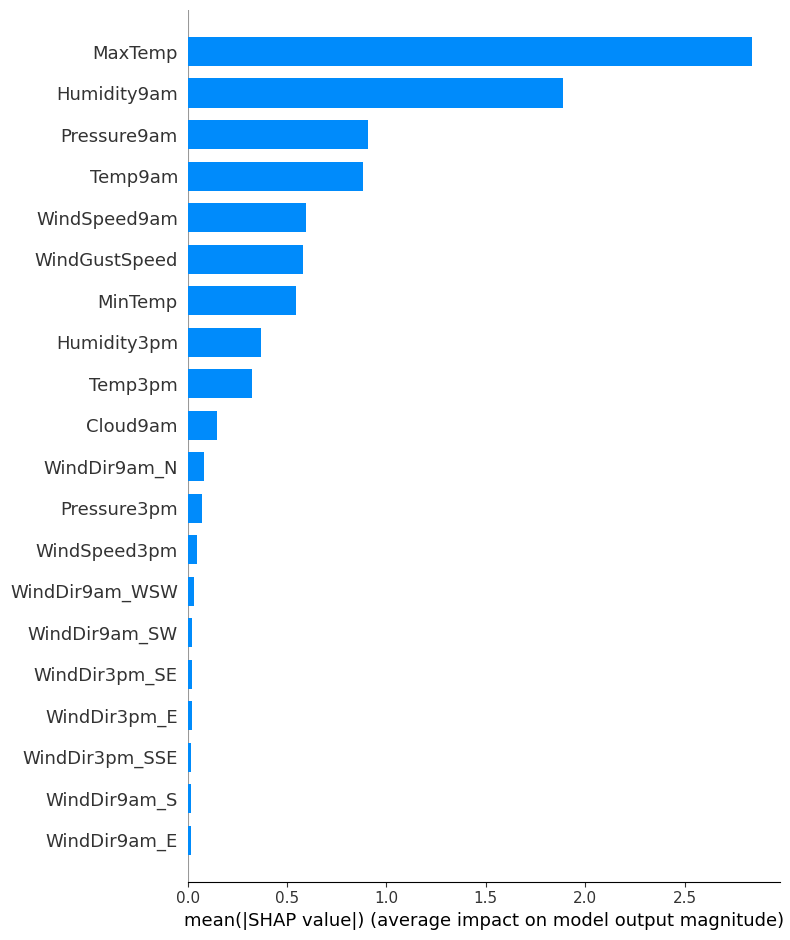

In [195]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type="bar")

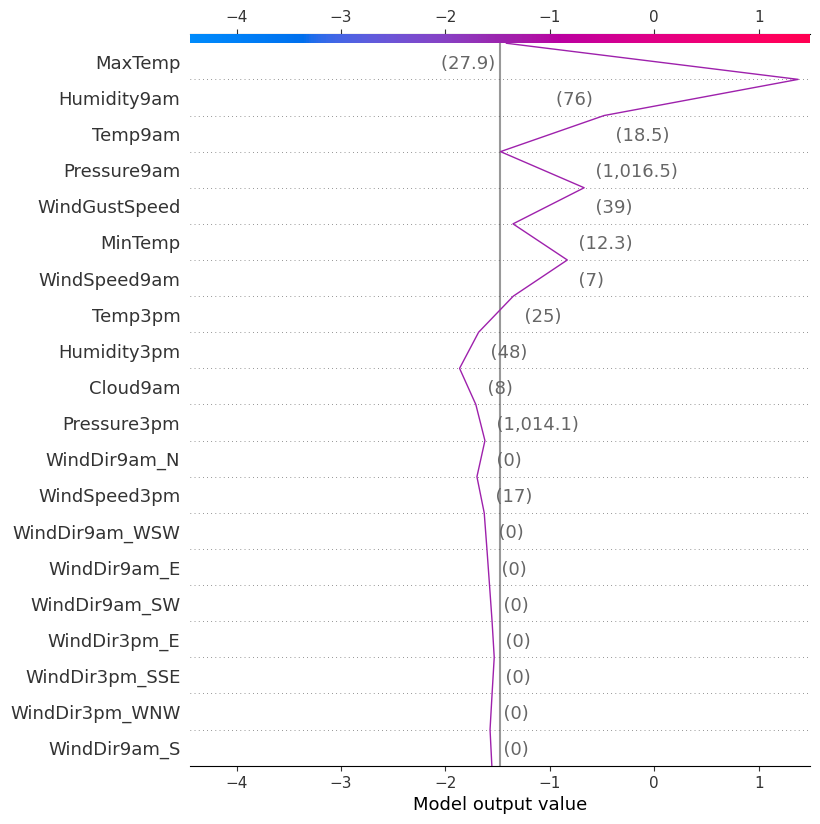

In [196]:
shap.decision_plot(explainer.expected_value, features=X_train, shap_values= shap_values[4776], feature_names=list(X.columns))

In [197]:
df_shap = pd.DataFrame(shap_values)
df_shap

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
1,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
2,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
3,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
4,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109090,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
109091,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
109092,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
109093,-0.520111,-2.793554,0.681277,0.516938,-0.069707,1.857131,0.182326,-0.800982,-0.087269,-0.155618,...,-0.000181,-0.006432,-0.003068,-0.007372,0.020337,-0.001751,-0.000148,-0.001855,0.019676,-0.002241


In [198]:
X_train.columns

Index(['MinTemp', 'MaxTemp', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Temp9am', 'Temp3pm', 'WindGustDir_E', 'WindGustDir_ENE',
       'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE',
       'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE',
       'WindGustDir_SSE', 'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W',
       'WindGustDir_WNW', 'WindGustDir_WSW', 'WindDir9am_E', 'WindDir9am_ENE',
       'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE',
       'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE',
       'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_W',
       'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_E', 'WindDir3pm_ENE',
       'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE',
       'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE',
     

In [199]:
prefixes = ['WindGustDir'	,'WindDir9am', 'WindDir3pm',]


In [200]:
df_shap.columns = X_train.columns
df_shap

,MinTemp,MaxTemp,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
1,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
2,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
3,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
4,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109090,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
109091,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
109092,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,...,0.000464,-0.006615,-0.003179,-0.025532,0.018934,-0.001751,0.000440,-0.001982,0.006676,-0.001701
109093,-0.520111,-2.793554,0.681277,0.516938,-0.069707,1.857131,0.182326,-0.800982,-0.087269,-0.155618,...,-0.000181,-0.006432,-0.003068,-0.007372,0.020337,-0.001751,-0.000148,-0.001855,0.019676,-0.002241


In [202]:
to_merge = [ (key,[ n for n in X_train.columns if n.find(key)>-1]) for key in prefixes]
to_merge

[('WindGustDir',
  ['WindGustDir_E',
   'WindGustDir_ENE',
   'WindGustDir_ESE',
   'WindGustDir_N',
   'WindGustDir_NE',
   'WindGustDir_NNE',
   'WindGustDir_NNW',
   'WindGustDir_NW',
   'WindGustDir_S',
   'WindGustDir_SE',
   'WindGustDir_SSE',
   'WindGustDir_SSW',
   'WindGustDir_SW',
   'WindGustDir_W',
   'WindGustDir_WNW',
   'WindGustDir_WSW']),
 ('WindDir9am',
  ['WindDir9am_E',
   'WindDir9am_ENE',
   'WindDir9am_ESE',
   'WindDir9am_N',
   'WindDir9am_NE',
   'WindDir9am_NNE',
   'WindDir9am_NNW',
   'WindDir9am_NW',
   'WindDir9am_S',
   'WindDir9am_SE',
   'WindDir9am_SSE',
   'WindDir9am_SSW',
   'WindDir9am_SW',
   'WindDir9am_W',
   'WindDir9am_WNW',
   'WindDir9am_WSW']),
 ('WindDir3pm',
  ['WindDir3pm_E',
   'WindDir3pm_ENE',
   'WindDir3pm_ESE',
   'WindDir3pm_N',
   'WindDir3pm_NE',
   'WindDir3pm_NNE',
   'WindDir3pm_NNW',
   'WindDir3pm_NW',
   'WindDir3pm_S',
   'WindDir3pm_SE',
   'WindDir3pm_SSE',
   'WindDir3pm_SSW',
   'WindDir3pm_SW',
   'WindDir3pm_W',
 

In [203]:
df_shap.columns

Index(['MinTemp', 'MaxTemp', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Temp9am', 'Temp3pm', 'WindGustDir_E', 'WindGustDir_ENE',
       'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE', 'WindGustDir_NNE',
       'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE',
       'WindGustDir_SSE', 'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W',
       'WindGustDir_WNW', 'WindGustDir_WSW', 'WindDir9am_E', 'WindDir9am_ENE',
       'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE',
       'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_SE',
       'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW', 'WindDir9am_W',
       'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_E', 'WindDir3pm_ENE',
       'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE',
       'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE',
     

In [204]:
for key, cols in to_merge:
    df_shap[key] = df_shap[cols].apply(sum, axis=1)
    df_shap.drop(cols, axis=1, inplace=True)
    
df_shap

,MinTemp,MaxTemp,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Temp9am,Temp3pm,WindGustDir,WindDir9am,WindDir3pm
0,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,0.861990,0.343164,-0.024917,-0.061390,-0.023836
1,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,0.861990,0.343164,-0.024917,-0.061390,-0.023836
2,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,0.861990,0.343164,-0.024917,-0.061390,-0.023836
3,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,0.861990,0.343164,-0.024917,-0.061390,-0.023836
4,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,0.861990,0.343164,-0.024917,-0.061390,-0.023836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109090,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,0.861990,0.343164,-0.024917,-0.061390,-0.023836
109091,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,0.861990,0.343164,-0.024917,-0.061390,-0.023836
109092,-0.530804,-2.819891,0.582895,0.631917,-0.021954,1.934620,0.405764,-0.900965,-0.045045,0.143592,0.861990,0.343164,-0.024917,-0.061390,-0.023836
109093,-0.520111,-2.793554,0.681277,0.516938,-0.069707,1.857131,0.182326,-0.800982,-0.087269,-0.155618,0.993241,0.332422,-0.030561,-0.052934,0.007987


In [205]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [206]:
X_train_undummified = undummify(X_train)
X_train_undummified

,MinTemp,MaxTemp,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Temp9am,Temp3pm,WindGustDir,WindDir9am,WindDir3pm
47410,12.3,27.9,39.0,7.0,17.0,76.0,48.0,1016.5,1014.1,8.0,18.5,25.0,SSW,SSE,WSW
143279,26.6,38.5,63.0,19.0,41.0,58.0,52.0,1012.4,1008.1,2.0,31.0,20.0,ESE,NNW,S
49499,9.4,23.7,24.0,7.0,9.0,76.0,39.0,1019.9,1017.3,7.0,14.4,23.2,N,W,NNW
59037,2.6,15.5,37.0,17.0,20.0,78.0,52.0,1027.3,1025.4,1.0,9.2,14.5,SE,SSE,SSE
50020,9.0,13.8,30.0,9.0,13.0,77.0,84.0,1021.4,1017.7,7.0,10.1,11.3,ESE,NNE,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90115,24.7,31.9,37.0,9.0,15.0,71.0,70.0,1012.6,1009.9,7.0,29.9,31.3,SSE,SE,ENE
33053,19.7,26.2,39.0,9.0,20.0,88.0,58.0,1019.7,1018.0,8.0,20.7,25.4,ESE,S,SSW
128972,16.1,25.6,35.0,17.0,26.0,58.0,53.0,1025.2,1021.1,7.0,20.7,23.1,W,ENE,ESE
137471,13.4,38.8,35.0,19.0,24.0,14.0,4.0,1013.0,1007.9,0.0,31.7,38.3,NW,NE,E


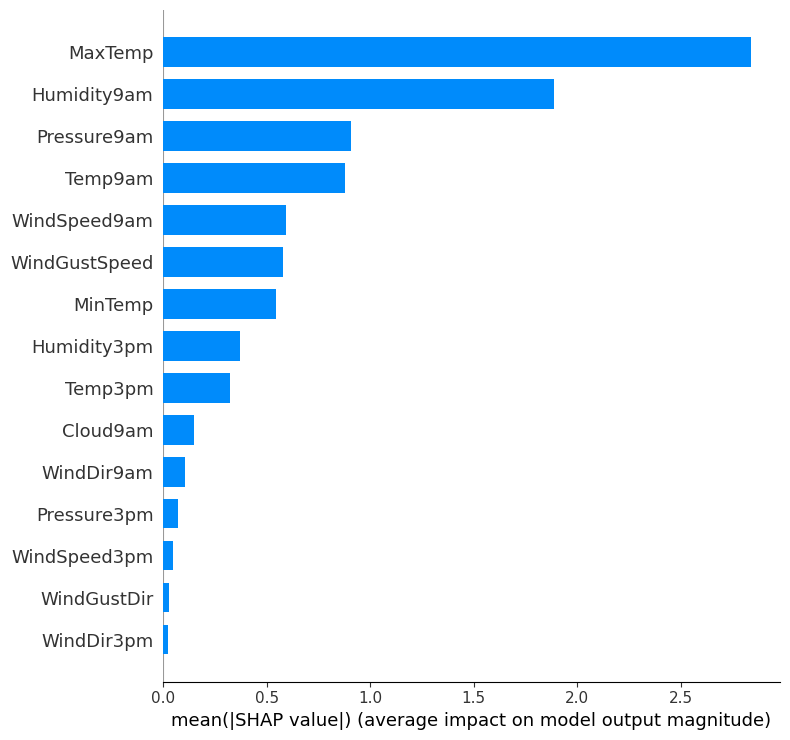

In [207]:
shap.summary_plot(df_shap, features=X_train_undummified, feature_names=X_train_undummified.columns, plot_type="bar")

https://shap-lrjball.readthedocs.io/en/latest/api.html#other-explainers